In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [2]:
train_dir = r"D:\University\0 دانشگاه علم و صنعت ایران\0 نیمسال های تحصیلی\7 ترم هفت\6 هوش مصنوعی\Project\Datasets\4 RAF-DB\archive\DATASET\train" 
test_dir = r"D:\University\0 دانشگاه علم و صنعت ایران\0 نیمسال های تحصیلی\7 ترم هفت\6 هوش مصنوعی\Project\Datasets\4 RAF-DB\archive\DATASET\test"   

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D, Reshape, multiply, ReLU, Add, Input)
from tensorflow.keras.models import Sequential, Model

# SEBlock Implementation
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(channels // reduction, activation='relu')(x)
    x = Dense(channels, activation='sigmoid')(x)
    x = Reshape((1, 1, channels))(x)
    return multiply([input_tensor, x])

# Residual Block Implementation
def residual_block(input_tensor, filters, stride=1):
    shortcut = input_tensor

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Modified Model
def build_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)

    # Initial Conv Blocks
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (5, 5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Add SEBlock
    x = se_block(x)

    # Residual Blocks
    x = residual_block(x, 512, stride=1)
    x = residual_block(x, 512, stride=2)

    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build and Compile Model
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │    204,928 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    590,336 │ dropout_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 512) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 6, 6, 512) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ dropout_2[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     16,416 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │     16,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 512) │          0 │ dense_1[0][0]   

 Total params: 11,880,487 (45.32 MB)

 Trainable params: 11,872,423 (45.29 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [4]:
img_size=48

In [5]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [6]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 9819 images belonging to 7 classes.
Found 611 images belonging to 7 classes.


In [7]:
model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [8]:
epochs = 45
batch_size = 64

In [9]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

c:\Users\A\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45
154/154 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.2608 - loss: 2.2288 - val_accuracy: 0.3879 - val_loss: 1.6919
Epoch 2/45
154/154 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3979 - loss: 1.7144 - val_accuracy: 0.4190 - val_loss: 1.5887
Epoch 3/45
154/154 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.4752 - loss: 1.4746 - val_accuracy: 0.4812 - val_loss: 1.4680
Epoch 4/45
154/154 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.5338 - loss: 1.3145 - val_accuracy: 0.5221 - val_loss: 1.4247
Epoch 5/45
154/154 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.5953 - loss: 1.1533 - val_accuracy: 0.6121 - val_loss: 1.0739
Epoch 6/45
154/154 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6266 - loss: 1.0398 - val_accuracy: 0.6498 - val_loss: 1.0110
Epoch 7/45
154/154 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6526 - loss: 0.9532 - val_accuracy: 0.6792 - val_loss: 0.9526
Epoch 8/45
154/154 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.6767 - loss: 0.8857 - val_accu

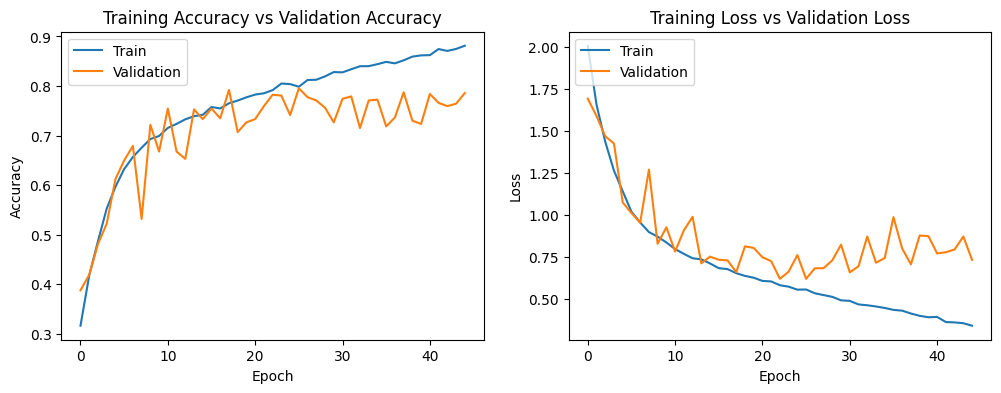

In [10]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [11]:
model.save_weights('model_weights_rafdb.weights.h5')

In [12]:
model.save('model_rafdb.h5')  # No restriction on `.weights.h5` here